# OTE-01: Initial Image Mosaic

Steps:
- Perturb the primary and secondary mirrors to reflect expectations for initial deployment
- Record the tilt of each PM and remove the piston/tip/tilt
- Generate segment PSFs
- ... figure out how to turn those PSFS into MIRAGE simulations

> Email from Marshall:
- Create 18 independent segment PSFs centered on each segment, each with some suitably small size rather than gigantic: 
    - Apply random perturbations as you are doing. 
    - For each segment, cut out just that segment from the OPD map (using the one_segment_pupil helper function in WebbPSF).
    - This part’s somewhat tricky. For each segment we will want to record what the tip/tilt  is, then zero it out before creating the PSF (so that we get the PSF centered on where the segment is). We can use the tip/tilt values in the OPD to compute the equivalent vector to where that PSF would be. 
    - End result should be 18 separate PSF arrays, plus for each one a tip/tilt vector saying where that should appear relative to the center of the PSF array.
- Iterate over the list of targets in MIRAGE
- For each target, iterate over the list of 18 PSFs and their offsets. 
- Compute the apparent location of that PSF as the sum of the coordinates that star would normally have in the field of view plus the offset to that PSF.
- If that PSF falls inside the detector field of view somewhere, put it there. Otherwise, skip that PSF. 

In [56]:
# Standard Library Imports
from glob import glob
import multiprocessing
import os
import re
import sys
import time
import yaml

# Third Party Imports
from astropy.io import ascii as asc
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pprint
import pysiaf
import webbpsf

# Local Imports
from mirage import imaging_simulator
from mirage.apt import apt_inputs
from mirage.catalogs import get_catalog
from mirage.dark import dark_prep
from mirage.psf import psf_library, psf_selection
from mirage.ramp_generator import obs_generator
from mirage.seed_image import catalog_seed_image
from mirage.yaml import yaml_generator, write_observationlist

# View matplotlib plots inline
%matplotlib inline

### Define location of input and output files

In [2]:
# Where the pointing and XML file for this particular OTE CAR are located
ote_dir = '/Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/'

# Where the input PSF FITs files will be saved to
library_root_dir = '/user/lchambers/OTECommSims/OTE01_library/'

In [3]:
prop_id = 1134

# Change if you named your files differently.
root = 'OTE01-{}-reduced_mosaic'.format(prop_id)

pointing_file = os.path.join(ote_dir, '{}.pointing'.format(root))
xml_file = os.path.join(ote_dir, '{}.xml'.format(root))

---
# First, simulate the OTE state

In [51]:
sys.path.insert(0,'../Initial_Deployment/')
import deployments

In [52]:
nc = webbpsf.NIRCam()
nc.filter = 'F212N'
nc, ote = webbpsf.enable_adjustable_ote(nc)

deployment_errors = deployments.get_deployment_errors(reduction_factor=0.2)
ote, segment_tilts = deployments.apply_deployment_errors(ote, deployment_errors)
ote = deployments.remove_piston_tip_tilt(ote)

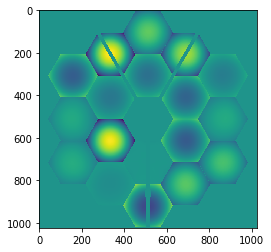

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	     0.0000     0.0000     0.0000    12.3100    48.9655    -0.2842
A2	     0.0000     0.0000     0.0000   -29.4440   -37.8579     6.1082
A3	     0.0000     0.0000     0.0000     7.4564   -48.5483     5.0639
A4	     0.0000     0.0000     0.0000     8.8539   -36.1663     3.5899
A5	     0.0000     0.0000     0.0000   -51.5632    -8.7903     2.7129
A6	     0.0000     0.0000     0.0000    63.3236   -43.9425   -13.2667
B1	     0.0000     0.0000     0.0000   -69.0288     9.0679     8.6392
C1	     0.0000     0.0000     0.0000   -47.6952    -0.4455    -6.2162
B2	     0.0000     0.0000     0.0000   -44.6182   -24.5979    -5.3973
C2	     0.0000     0.0000     0.0000   -71.4280     9.6261    -2.9124
B3	     0.0000     0.0000     0.0000    -2.9032   -41.6939     2.1904
C3	     0.0000     0.0000     0.0000     7.5376    3

In [53]:
plt.imshow(ote.opd)
plt.show()
ote.print_state()
print(segment_tilts)

---
# Second, generate PSF library files

In [55]:
# Generate and save 18 segment PSFs
for i in range (18):
    # Restrict the pupil to the current segment
    i_segment = i + 1
    segname = webbpsf.webbpsf_core.segname(i_segment)
    pupil = webbpsf.webbpsf_core.one_segment_pupil(i_segment)
    ote.amplitude = pupil[0].data
    
    # Add header keywords about segment
    hdr = fits.Header()
    hdr['SEGID'] = (i_segment, 'ID of the mirror segment')
    hdr['SEGNAME'] = (segname, 'Name of the mirror segment')
    hdr['XTILT'] = (round(segment_tilts[i, 0], 2), 'X tilt of the segment in microns')
    hdr['YTILT'] = (round(segment_tilts[i, 1], 2), 'Y tilt of the segment in microns')
    
    fov_pixels = 1024
    library_filename = 'nircam_{}_fovp{}_samp1_npsf1_seg{:02d}.fits'.format(nc.filter.lower(), fov_pixels, i_segment)
    c = psf_library.CreatePSFLibrary('NIRCam', filters=nc.filter, detectors='NRCA3', 
                                     fov_pixels=fov_pixels, oversample=1, num_psfs=1, 
                                     fileloc=library_root_dir, filename=library_filename,
                                     ote=ote, overwrite=False, header_addons=hdr)
    c.create_files()
    
    print('Completed segment {}'.format(i + 1))

Using custom OPD

Starting filter: F212N
  Running detector: NRCA3
  Saving file: /user/lchambers/OTECommSims/OTE01_library/nircam_f212n_fovp1024_samp1_npsf1_seg01.fits
Completed segment 1
Using custom OPD

Starting filter: F212N
  Running detector: NRCA3
  Saving file: /user/lchambers/OTECommSims/OTE01_library/nircam_f212n_fovp1024_samp1_npsf1_seg02.fits
Completed segment 2
Using custom OPD

Starting filter: F212N
  Running detector: NRCA3
  Saving file: /user/lchambers/OTECommSims/OTE01_library/nircam_f212n_fovp1024_samp1_npsf1_seg03.fits
Completed segment 3
Using custom OPD

Starting filter: F212N
  Running detector: NRCA3
  Saving file: /user/lchambers/OTECommSims/OTE01_library/nircam_f212n_fovp1024_samp1_npsf1_seg04.fits
Completed segment 4
Using custom OPD

Starting filter: F212N
  Running detector: NRCA3
  Saving file: /user/lchambers/OTECommSims/OTE01_library/nircam_f212n_fovp1024_samp1_npsf1_seg05.fits
Completed segment 5
Using custom OPD

Starting filter: F212N
  Running dete

---
# Third, create `.yaml` files for each exposure

### Get the source catalogs

In [4]:
# Get SW and LW catalogs
cats = get_catalog.get_all_catalogs(pointing_file, prop_id)
target_coords, catalog_filenames_sw, catalog_filenames_lw = cats

cat_dict = {'nircam': {'lw': catalog_filenames_lw,
                       'sw': catalog_filenames_sw}}

Target coordinates:  146.87731 63.24781
Shortwave catalog file 2MASS_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.
Longwave catalog file WISE_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.


In [5]:
# Create a series of data simulator input yaml files from APT files
# (Within this, create the observation table.)
yaml_dir = os.path.join(ote_dir, 'yamls')
yam = yaml_generator.SimInput(input_xml=xml_file, pointing_file=pointing_file,
                              catalogs=cat_dict,
                              verbose=True, output_dir=yaml_dir, simdata_output_dir=ote_dir)
yam.psf_paths = os.path.expandvars(library_root_dir)
yam.expand_catalog_for_segments = True
yam.create_inputs()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `1` labelled `Central` uses template `NircamImaging`
APTObservationParams Dictionary holds 0 entries before reading template
Element PrimaryDithers not found, use default value.
Dictionary read from template has 1 entries.
Found 6 tile(s) for observation 1 Central
Found 2 visits with numbers: [1, 2]
APTObservationParams Dictionary holds 6 entries after reading template (+6 entries)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `2` labelled `W` uses template `NircamImaging`
APTObservationParams Dictionary holds 6 entries before reading template
Element PrimaryDithers not found, use default value.
Dictionary read from template has 1 entries.
Found 39 tile(s) for observation 2 W
Found 14 visits with numbers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
APTObservationParams Dictionary holds 45 entries after re

In [6]:
# Print information about the yaml files that were generated.
yfiles = glob(os.path.join(yaml_dir, 'jw*yaml'))

obs_numbers = [f.split('/')[-1].split('_')[0] for f in yfiles]
all_obs_numbers = list(set(obs_numbers))
all_obs_numbers.sort()

n_obs = len(set([int(number[9:11]) for number in all_obs_numbers]))

print('Found {} yaml files.'.format(len(obs_numbers)))
print('({} exposures across {} observations)'.format(len(all_obs_numbers), n_obs))
# pprint.pprint(all_obs_numbers)

Found 2640 yaml files.
(90 exposures across 7 observations)


---
# 3.5th, examine where the sources will fall in an example exposure

Example files for each pointing:
--------------------------------
1. jw01134001002_01105_00001_nrcb4.yaml
2. jw01134001002_01106_00001_nrcb2.yaml
3. jw01134001001_01101_00001_nrcb3.yaml
4. jw01134001001_01103_00001_nrca2.yaml
5. jw01134001001_01102_00001_nrca5.yaml
8. jw01134001001_01104_00001_nrcb3.yaml


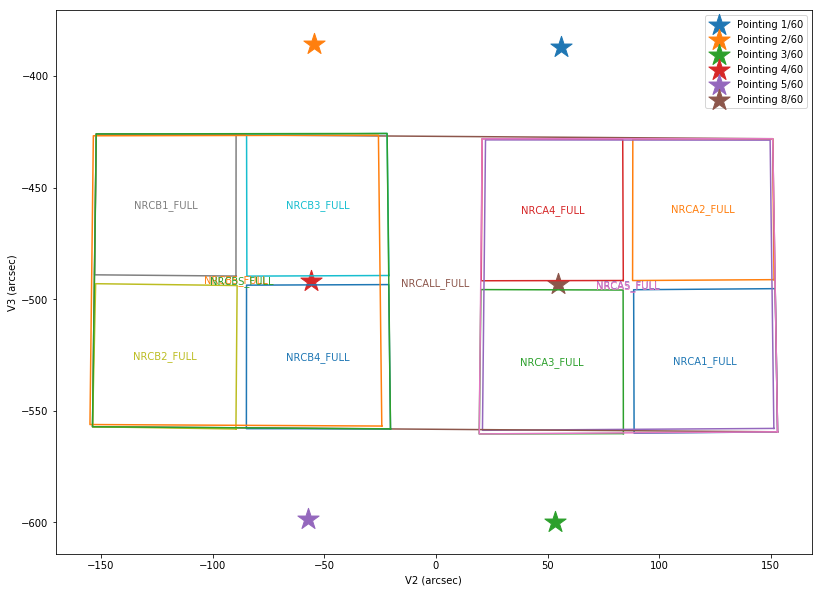

In [10]:
# Examine apertures and V2/V3 references for each array/subarray
nc_siaf = pysiaf.Siaf('NIRCam')
nc_full = nc_siaf['NRCA3_FULL']

plt.figure(figsize=(15,10))
for apername in sorted(nc_siaf.apernames):
    a = apername
    if ('_FULL' in a) and ('OSS' not in a) and ('MASK' not in a) and (a[-1] != 'P'):
        nc_siaf[a].plot(frame='tel', name_label=a, fill_color='white')
plt.gca().invert_xaxis()

# Compare V2/V3 of targets (from .pointing file)
all_pointings = set([(v2, v3, filename) for v2, v3, filename in zip(yam.info['v2'], 
                                                                yam.info['v3'], 
                                                                yam.info['yamlfile']) if 'jw01134001' in filename])

print('Example files for each pointing:')
print('--------------------------------')
plotted_points = []
for i_point, (v2, v3, filename) in enumerate(all_pointings):
    if (v2, v3) not in plotted_points:
        plotted_points.append((v2, v3))
        plt.scatter(v2, v3, marker='*', s=500, 
                    label='Pointing {}/{}'.format(i_point + 1, len(all_pointings)))
        print('{}. {}'.format(i_point + 1, filename))

plt.legend()

plt.show()

In [57]:
# Save the yam.info dictionary to a yaml file that can be opened
with open('OTE-10-yam.info.yaml', 'w') as outfile:
    yaml.dump(yam.info, outfile, default_flow_style=False)

In [49]:
# Select one YAML to estimate where the sources will be
test_yaml_filename = 'jw01134001002_01106_00001_nrca3.yaml'
test_yaml = os.path.join(yaml_dir, test_yaml_filename)
print(test_yaml)
yaml_ind = np.where(np.array(yam.info['yamlfile']) == test_yaml_filename)[0][0]

/Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/yamls/jw01134001002_01106_00001_nrca3.yaml


In [64]:
# Calculate V2/V3 locations of aperture, target, and sources

# Examine apertures and V2/V3 references for each array/subarray
nc_siaf = pysiaf.Siaf('NIRCam')
nc_a3 = nc_siaf['NRCA3_FULL']
nc_all = nc_siaf['NRCALL_FULL']

# Get the target RA/Dec
target_ra = float(yam.info['ra'][yaml_ind])
target_dec = float(yam.info['dec'][yaml_ind])
print('Target RA/Dec:', target_ra, target_dec)

# Get the aperture pointing - THIS IS FOR NRCALL_FULL
pointing_v2 = yam.info['v2'][yaml_ind]
pointing_v3 = yam.info['v3'][yaml_ind]

# Get the aperture RA/Dec - THIS IS FOR NRCA3_FULL
pointing_ra = float(yam.info['ra_ref'][yaml_ind])
pointing_dec = float(yam.info['dec_ref'][yaml_ind])
print('NRCA3 Pointing RA/Dec:', pointing_ra, pointing_dec)

# Generate the attitude matrix to convert RA/Dec to V2/V3
position_angle = float(yam.info['PAV3'][yaml_ind])
attitude_ref = pysiaf.utils.rotations.attitude(
    pointing_v2, pointing_v3, target_ra, target_dec, position_angle
)

# Get the V2/V3 positions of all sources
sw_catalog_file = yam.info['sw_ptsrc'][yaml_ind]
sw_catalog = asc.read(sw_catalog_file)
v2, v3 = pysiaf.utils.rotations.getv2v3(attitude_ref, sw_catalog['x_or_RA'], sw_catalog['y_or_Dec'])

# Get the V2/V3 position of the target (the same as the NRCALL pointing)
target_v2, target_v3 = pysiaf.utils.rotations.getv2v3(attitude_ref, target_ra, target_dec)

# Get the V2/V3 position of the aperture pointing
a3_v2, a3_v3 = pysiaf.utils.rotations.getv2v3(attitude_ref, pointing_ra, pointing_dec)

# Add offsets for each segment
PSFCollection = psf_selection.PSFCollection(
    'NIRCam', 'NRCA3', 'F212N', library_root_dir, True
)

Target RA/Dec: 146.87731 63.24781
NRCA3 Pointing RA/Dec: 146.77196760996176 63.23422083399082


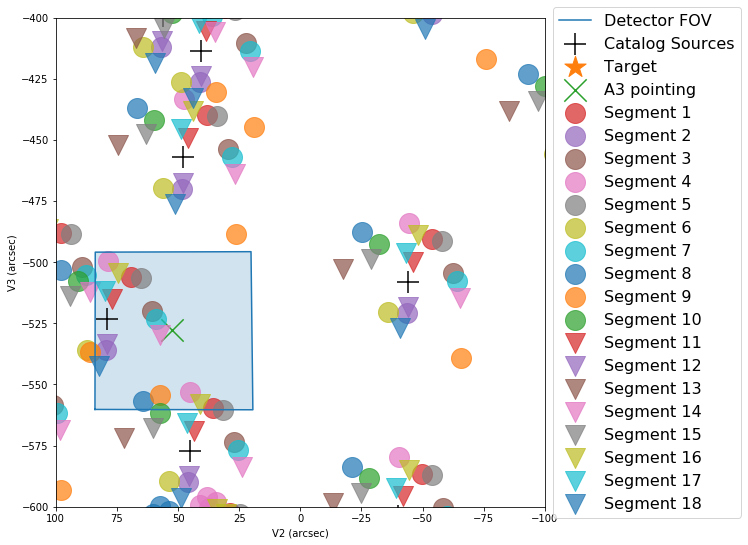

In [66]:
# Plot V2/V3 locations of aperture, target, and sources

fig, ax = plt.subplots(1, 1, figsize=(15,10))
nc_a3.plot(frame='tel', fill_color=None, label='Detector FOV', fill_alpha=0.2)

# Plot catalog sources
plt.scatter(v2, v3, label='Catalog Sources', marker='+', s=500, c='black')

# Plot the target (the same as the NRCALL pointing)
plt.scatter(target_v2, target_v3, label='Target', marker='*', s=500)

# Plot the center of aperture pointing
plt.scatter(a3_v2, a3_v3, label='A3 pointing', marker='x', s=500)

# Plot segment sources
for i_segment in np.arange(1, 19):
    marker = 'o'
    if i_segment > 10:
        marker = 'v'
    x_arcsec, y_arcsec = PSFCollection.get_segment_offset(i_segment, 'NRCA3')
    plt.scatter(v2 - x_arcsec, v3 + y_arcsec, 
                label='Segment {}'.format(i_segment), marker=marker, s=400, alpha=0.7)

# Just show the area close to the detector
plt.xlim(100, -100)
plt.ylim(-600, -400)

# Shrink current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width * 0.9, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=16, facecolor=None)

plt.show()

---
# Fourth, actually generate images

In [51]:
test_yaml = os.path.join(yaml_dir, 'jw01134001002_01106_00001_nrca3.yaml')
cat = catalog_seed_image.Catalog_seed()
cat.paramfile = test_yaml
cat.make_seed()

Requested readout pattern BRIGHT1 is valid. Using the nframe = 1 and nskip = 1
No galaxy catalog provided in yaml file.
NOTE: Using pre-delivery SIAF data for NIRCam
NRCA3_FULL
SIAF: Requested NRCA3_FULL   got NRCA3_FULL
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Expanding the source catalog for 18 mirror segments

Calculating point source lists for segment 1
    Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (9.65391612948, 17.3446456628)
    Position angle =  111.0
    Number of point sources found within the requested aperture: 3

Calculating point source lists for segment 2
    Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (-0.6059574760944385, -12.730827809990608)
    Position angle =  111.0
    Number of point sources found within the requested aperture: 1

Calculating point source lists for segme


Calculating point source lists for segment 17
    Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (-0.9314976028828011, 11.451624616034724)
    Position angle =  111.0
    Number of point sources found within the requested aperture: 2

Calculating point source lists for segment 18
    Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (-3.2971519277696717, -19.17965480068036)
    Position angle =  111.0
    Number of point sources found within the requested aperture: 1
Seed image is 2D.
Seed image and segmentation map saved as /Users/lchambers/TEL/mirage/OTECommissioning/OTE01_reducedmosaic/jw01134001002_01106_00001_nrca3_uncal_F212N_seed_image.fits
Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.


In [25]:
def show(array,title,min=0,max=1000, match_focal_plane=True):
    plt.figure(figsize=(12,12))
    plt.imshow(array,clim=(min,max))
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04).set_label('DN$^{-}$/s')
    if match_focal_plane:
        # origin in lower right corner
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
    plt.show()

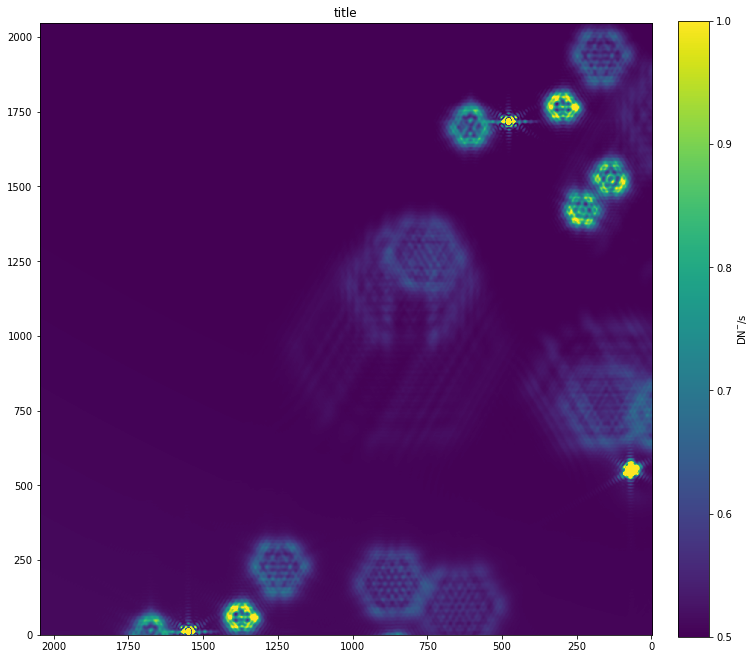

In [78]:
show(cat.seedimage, 'title', min=0.5, max=1e0)

---
# Fifth, combine into a mosaic

In [68]:
# Get list of YAML files for observation 1 (all 10 detectors)
obs1_visit1_files = glob(os.path.join(yaml_dir, 'jw01134001*yaml'))
print('{} yaml files found in program APT 1134 Observation 1'.format(len(obs1_visit1_files)))

60 yaml files found in program APT 1134 Observation 1


In [ ]:
# Generate "mosaic" from images
obs1_fits_files = glob(os.path.join(ote_dir, 'jw*linear.fits'))

with fits.open(obs1_fits_files[0]) as hdu:
    hdu.info()

for f in sorted(obs1_fits_files):
    print(f.split('/')[-1])
    with fits.open(f) as hdu:
        print(hdu[0].header['TARG_RA'])
        print(hdu[0].header['RA_V1'])
        print(hdu[0].header['XOFFSET'], hdu[0].header['YOFFSET'])
        print()